Midterm DA 320

After learning about data pipelines and NoSQL databases I wanted to see if I could use the data in my database. After creating a couple views of out the pipelines, I had movie data ready to be used. 

Now I was wondering what the top actresses and genres were for 2011; while incorporating a ML learning model to help me categorize the data.

Lets begin by scraping the data off the webistes.

In [ ]:
import urllib3
import certifi

link = "https://www.metacritic.com/browse/movies/score/metascore/year/filtered?year_selected=2017&sort=desc&view=detailed "


user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:105.0) Gecko/20100101 Firefox/105.0"
# construct a python request pool


http = urllib3.PoolManager(ca_certs=certifi.where())

# initiate a web request

response = http.request('GET',link, headers = {"User-Agent": user_agent})

# Convert the result from raw bytes to text

page_content = str(response.data, "utf-8")

# Check if data convertion succeeded and how much data got collected

print(response.status)
print(f"Fetched {len(page_content)} characters from {link}.")

# if Request == 200, HTTP request succeeded
# the len of the data string shows the number of char in the page

# Used prof.spence code to bypass the blocking 


In [ ]:
import re

# The code in this block is used to extract information from the website using regular expressions.
# Code also displays the results of the querying and the first value of the information in the array.

# making movie_titles array scraping the information from the page_content using a regular expression.
movie_titles = re.findall("class=\"title\"><h3>(.*)<\/h3><\/a>", page_content)

# Displaying the extracted information
print(f"Found {len(movie_titles)} Movie titles in the 2017 Metacritic page. The first Movie is {movie_titles[0]}")

release_date = re.findall("class=\"clamp-details\">\s*<span>(.*) (.*)\, (.*)<\/span>", page_content)
print(f"Found {len(release_date)} Release dates in the 2017 Metacritic page. The release date for Dunkirk is {release_date[0]} ")

summary = re.findall("<div class=\"summary\">\s*(.*)", page_content)

print(f"Found {len(summary)} summaries in the 2017 Metacritic page. The summary for Dunkirk is {summary[0]}")

metascore = re.findall("<div class=\"metascore_w large movie positive\">(.*)\s*<\/div>\s*<\/a>\s*<\/div>\s*<div", page_content)

print(f"Found {len(metascore)} metascores in the 2017 Metacritic page. The metascore for Dunkirk is {metascore[0]}")

image_url = re.findall("<a href=\"\/movie\/.*\"><img src=\"https:(.*)", page_content)

print(f"Found {len(image_url)} image URL's in the 2017 Metacritic page. The URL for Dunkirk is {image_url[0]}")

In [ ]:
import pandas as pd
# creating a dictionary based on the data that was extracted
dataset = {
    "Title": movie_titles,
    "Release Date": release_date,
    "metascore": metascore,
    "image url": image_url,
    "summary": summary,
}

# making a data frame using the dataset above
dataFrame = pd.DataFrame(dataset)
# making the index in the data frame start at 1 instead of 0 (Courtesy of Jooyeon Park)
dataFrame.index += 1
# displaying the dataframe, used Michael Etelamaki's code to display the dataframe at the end
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    display(dataFrame)

The data was sucessfully scraped, after this I exported a csv and uploaded it to MongoDB. Here is the aggregation Pipeline I used.

Aggregation Pipeline:

/**
 * specifications: The fields to
 *   include or exclude.
 */
{
  runtime: {
    $convert: {
      input: "$runtime",
      to: "int",
      onError: "null",
    },
  },
  user_rating: {
    $convert: {
      input: "$user_rating",
      to: "double",
      onError: "null",
    },
  },
  votes: {
    $convert: {
      input: "$votes",
      to: "int",
      onError: "null",
    },
  },
  budget: {
    $convert: {
      input: "$budget",
      to: "int",
      onError: "null",
    },
  },
  opening_weekend: {
    $convert: {
      input: "$opening_weekend",
      to: "int",
      onError: "null",
    },
  },
  gross_sales: {
    $convert: {
      input: "$gross_sales",
      to: "int",
      onError: "null",
    },
  },
  release_date: {
    $convert: {
      input: "$release_date",
      to: "date",
      onError: "null",
    },
  },
  company: {
    $split: [
      {
        $toString: "$company",
      },
      ",",
    ],
  },
  companyTrimmed: {
    $map: {
      input: {
        $split: ["$company", ","],
      },
      as: "company_split",
      in: {
        $trim: {
          input: "$$company_split",
        },
      },
    },
  },
  genres: {
    $split: [
      {
        $toString: "$genres",
      },
      ",",
    ],
  },
  genresTrimmed: {
    $map: {
      input: {
        $split: ["$genres", ","],
      },
      as: "genres_split",
      in: {
        $trim: {
          input: "$$genres_split",
        },
      },
    },
  },
  cast: {
    $split: [
      {
        $toString: "$cast",
      },
      ",",
    ],
  },
  castTrimmed: {
    $map: {
      input: {
        $split: ["$cast", ","],
      },
      as: "cast_split",
      in: {
        $trim: {
          input: "$$cast_split",
        },
      },
    },
  },
  director: {
    $split: [
      {
        $toString: "$director",
      },
      ",",
    ],
  },
  directorTrimmed: {
    $map: {
      input: {
        $split: ["$director", ","],
      },
      as: "director_split",
      in: {
        $trim: {
          input: "$$director_split",
        },
      },
    },
  },
  mpaa_rating: {
    $arrayElemAt: [
      {
        $split: [
          {
            $toString: [
              {
                $ifNull: [
                  "$mpaa_rating",
                  "Not Rated",
                ],
              },
            ],
          },
          "::",
        ],
      },
      0,
    ],
  },
}

Now I will connect to the database and verify its working

In [1]:
import pymongo
import certifi
import json
import pandas as pd
from matplotlib import pyplot as plt
import re

# Fetching connection string

with open('C:\\Users\\ssilv\OneDrive\Documents\math 264\DA 320\secrets.json') as file:
    data = json.load(file)

secret_key = data['mongodb']

print(f"length of secret key {len(secret_key)}")

length of secret key 58


In [3]:
# connecting to the database using known good certificates

mongo_connection_string = data['mongodb']

client = pymongo.MongoClient(mongo_connection_string,tlsCAFile=certifi.where())

#fecthing the database

db = client['Metacritic_Data']

allCollections = db.list_collection_names()

print(f"Using MongoDB version {client.server_info()['version']}.")

print(allCollections)

ConfigurationError: The DNS query name does not exist: _mongodb._tcp.cluster.gbutctc.mongodb.net.

I would like to fetch the data from 2011 from both IMDB and Metacritic.
Using pandas I will then create a datafreame to store and transform the 2011 working data for both IMDB and Metacritic.

In [ ]:

IMDB_view = db['IMDB_Pipeline_View']

data = list(IMDB_view.find({}))


IMDB_df = pd.DataFrame(data)
IMDB_df['release_date'] = pd.to_datetime(IMDB_df['release_date'])
IMDB_df = IMDB_df[IMDB_df['release_date'].dt.year == 2011]




metacritic_view = db['Metacritic']

metacritic_data = list(metacritic_view.find({}))

meta_df = pd.DataFrame(metacritic_data)

meta_df['release_date'] = pd.to_datetime(meta_df['release_date'])
meta_df = meta_df[meta_df['release_date'].dt.year == 2011]

meta_df.score = pd.to_numeric(meta_df.score, errors = 'coerce')
meta_df.release_date = pd.to_datetime(meta_df.release_date, errors = "coerce")

print(IMDB_df)

# I would like to give thanks to my classmate Julie Nguyen for helping with this code

                            _id  runtime   
15924  646a7a2362ba37bc6927283d     85.0  \
16159  646a7a2562ba37bc69272928     90.0   
16262  646a7a2562ba37bc6927298f    125.0   
16263  646a7a2562ba37bc69272990    119.0   
16275  646a7a2562ba37bc6927299c    132.0   
...                         ...      ...   
17380  646a7a2662ba37bc69272ded     87.0   
17381  646a7a2662ba37bc69272dee     89.0   
17382  646a7a2662ba37bc69272def    112.0   
17383  646a7a2662ba37bc69272df0    109.0   
17384  646a7a2662ba37bc69272df1     80.0   

                                          title  user_rating   votes   
15924                             The Encounter          6.6    3417  \
16159                        The Lazarus Papers          4.1    3234   
16262                               Bridesmaids          6.8  289031   
16263                             The Rum Diary          6.1  104662   
16275      Mission: Impossible - Ghost Protocol          7.4  483423   
...                                    

I would like to merge the datasets using an inner join, and create a prompt for the ML classifier. I will also drop any NA values from the unified view, since its incomplete data.

In [ ]:
unified_view = pd.merge(IMDB_df ,meta_df, how = "inner", on = "title")

# dropping na values of the merged data

unified_view = unified_view.dropna()

print(unified_view)


                        _id_x  runtime                                 title   
0    646a7a2562ba37bc6927298f    125.0                           Bridesmaids  \
2    646a7a2562ba37bc6927299c    132.0  Mission: Impossible - Ghost Protocol   
4    646a7a2562ba37bc6927299e    107.0                                 Rango   
6    646a7a2562ba37bc692729a0    154.0        Transformers: Dark of the Moon   
7    646a7a2562ba37bc692729a1    139.0                      The Tree of Life   
..                        ...      ...                                   ...   
164  646a7a2562ba37bc69272aa1     86.0                             Apollo 18   
166  646a7a2562ba37bc69272aaf    106.0              Madea's Big Happy Family   
174  646a7a2562ba37bc69272acd     98.0                         A Better Life   
185  646a7a2562ba37bc69272ae6     84.0            Glee: The 3D Concert Movie   
188  646a7a2562ba37bc69272aee    105.0        Justin Bieber: Never Say Never   

     user_rating   votes     budget  op

Setting up a pipeline using distilBERT model for the "fill-mask" task. This applies the pipeline to each row of the data frame to predict the category of a movie based on its description and insters the predicted category into a new column.

In [ ]:
from transformers import pipeline

# Uses classification library published on https://huggingface.co/distilbert-base-uncased
classifier = pipeline("fill-mask", model="distilbert-base-uncased")

prompt_column = unified_view.apply(lambda row: f"{row['description']} The category of this movie is [MASK].", axis = 1)
unified_view.insert(0, "prompt", prompt_column)

category_column = unified_view.apply(lambda row: classifier(row['prompt'])[0]['token_str'], axis = 1)
unified_view.insert(0, "category", category_column)

c:\Users\ssilv\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


creating an empty array to store the data, and running a for loop so that the classifier goes through every entry and categorizes the data.

So now that all the data has been categorized and appended I can generate the graphs for the top 10 movie genres in 2011.

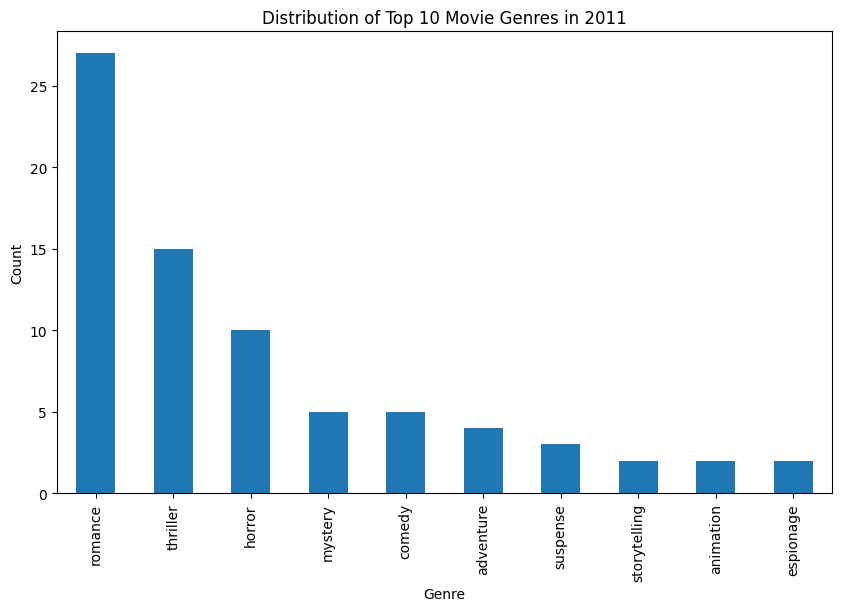

In [ ]:
categories = []

for description in unified_view['description']:
    
    genre_prediction = classifier(f"If there are any words that contain a feeling in a {description}. It belongs to the genre of [MASK].")
    genre = genre_prediction[0]['token_str'].lower()

    categories.append(genre)

unified_view['categories'] = categories

plt.figure(figsize = (10,6))

unified_view['categories'].value_counts().head(10).plot(kind='bar')

plt.title("Distribution of Top 10 Movie Genres in 2011")

plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

# I would like to give thanks to my classmate Jooyeon Park for helping with this code

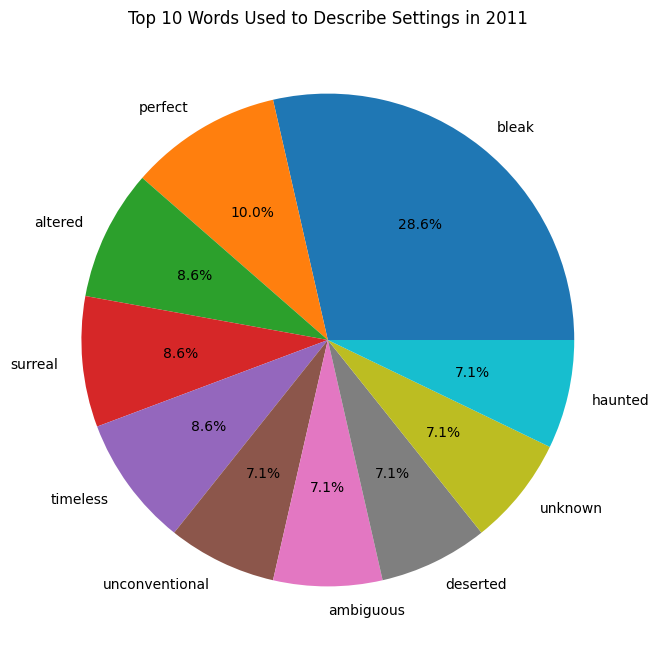

In [9]:
settings = []

for description in unified_view['description']:
    
    setting_prediction = classifier(f"What is the setting in {description}, the setting is [MASK].")
    setting = setting_prediction[0]['token_str'].lower()

    settings.append(setting)

unified_view['settings'] = settings

plt.figure(figsize = (12,8))

unified_view['settings'].value_counts().head(10).plot(kind='pie', autopct = '%1.1f%%')

plt.title("Top 10 Words Used to Describe Settings in 2011")
plt.ylabel('')

plt.show()

Using the data stored in my mongoDB I was able to utilize two separate pipelines; and created views that then could be used to fetch the data.

Using python I then performed the E.T.L. process to produce two graphs that answered two questions that I had about the data. 

These graphs were made using a machine learning model's output ("I used DistilBERT") and appending the data to the dataframe.

Based on the two graphs we can see that romance dominates the genres for this sample of data, and that at least a quarter of the movies settings can be 
described as "bleak".

We learned that the top genre for 2011 is romance, we could compare it to older data  and newer data to see if it is still the top genre. This way we can see if there is a pattern that we can spot over time.

The pie chart didn't bring a lot of inisght since it returned a couple of vague answers, in the future the prompt could be revisited to redce vagueness.